In [2]:
import csv as csv
import pandas as pd
import numpy as np
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
import re
import warnings
import seaborn as sns
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 

# 读取评论数据集
df = pd.read_csv('20200105-2u.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 3 columns):
userid     2945 non-null int64
content    2945 non-null object
label      2945 non-null int64
dtypes: int64(2), object(1)
memory usage: 69.1+ KB


In [4]:
col = ['content', 'label']
df = df[col]
df.head()

,content,label
0,数据压缩的目的就是要消除信息中的冗余,2
1,下载技术演变：1.主从架构方式2.断点续传方式3.多线程并行方式：如网络蚂蚁4.镜像服务器方...,2
2,智能终端集娱乐性和实用性为一身,3
3,终端将向定制化发展着重于语音识别系统的开发终端紧密服务于业务将是大势所趋未来终端的竞争将是平台竞争,2
4,1.不熟悉的网站不要随意点开，更不要随便输入账户和密码2.如需进行支付或重要操作时，免费WI...,4


In [5]:
cat=[]
for i in range(len(df['label'])):
    if df['label'][i]==1:
        cat.append('阐述')
    if df['label'][i]==2:
        cat.append('推理')
    if df['label'][i]==3:
        cat.append('判断')
    if df['label'][i]==4:
        cat.append('方法')
df['cat']=cat
df.head()

,content,label,cat
0,数据压缩的目的就是要消除信息中的冗余,2,推理
1,下载技术演变：1.主从架构方式2.断点续传方式3.多线程并行方式：如网络蚂蚁4.镜像服务器方...,2,推理
2,智能终端集娱乐性和实用性为一身,3,判断
3,终端将向定制化发展着重于语音识别系统的开发终端紧密服务于业务将是大势所趋未来终端的竞争将是平台竞争,2,推理
4,1.不熟悉的网站不要随意点开，更不要随便输入账户和密码2.如需进行支付或重要操作时，免费WI...,4,方法


In [6]:
cat_label_df = df[['cat','label']].drop_duplicates().sort_values('label').reset_index(drop=True)
cat_to_label = dict(cat_label_df.values)
label_to_cat = dict(cat_label_df[['label', 'cat']].values)
cat_label_df

,cat,label
0,阐述,1
1,推理,2
2,判断,3
3,方法,4


In [7]:
d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,cat,count
0,阐述,1591
1,推理,608
2,方法,447
3,判断,299


Text(0.5,0,'类目')

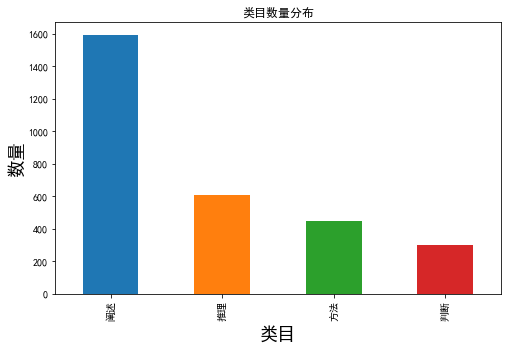

In [8]:
df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("类目数量分布")
plt.ylabel('数量', fontsize=18)
plt.xlabel('类目', fontsize=18)

In [9]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("stop_words.txt")

In [10]:
#删除除字母,数字，汉字以外的所有符号
df['content'] = df['content'].apply(remove_punctuation)
df.sample(15)

,content,label,cat
2747,系统工具软件磁盘碎片的清理与整理任务管理器等压缩软件工具用于文件的存储与传输下载工具下载资源...,2,推理
1913,它可以将图像电子表格文件文档图表等各种文件附加到数据库记录中,1,阐述
2668,也叫点位图或位图图像,1,阐述
602,对国家和政府而言加强立法完善隐私保护机制是十分必要和有效的,3,判断
1883,可以表达文字信息说明的更加清楚,2,推理
201,合理恰当的使用动画对动画设计时要注意场合以及动画的频度有些场合不适宜复杂的动画只需要简单的就...,3,判断
2034,1文本由语言文字和符号字符组成的数据文件,1,阐述
2869,3备注型包含长度在64000个字符内的文本字符串应用于长文本,1,阐述
2125,答采样量化编码解码存储,1,阐述
1643,6画图它提供了完整的绘图工具和选择颜料的调色板可以用来用来画图及存储屏幕打印图片,2,推理


In [11]:
#分词，并过滤停用词
df['content'] = df['content'].map(lambda x: ' '.join(jieba.cut(x))) #以空格分隔jieba分词结果
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\MAC\AppData\Local\Temp\jieba.cache
Loading model cost 1.219 seconds.
Prefix dict has been built succesfully.


,content,label,cat
0,数据压缩 的 目的 就是 要 消除 信息 中 的 冗余,2,推理
1,下载 技术 演变 1 主从 架构 方式 2 断点续传 方式 3 多线程 并行 方式 如 网络...,2,推理
2,智能 终端 集 娱乐性 和 实用性 为 一身,3,判断
3,终端 将 向 定制 化发展 着重于 语音 识别系统 的 开发 终端 紧密 服务 于 业务 将...,2,推理
4,1 不 熟悉 的 网站 不要 随意 点开 更 不要 随便 输入 账户 和 密码 2 如需 进...,4,方法


In [21]:
print(label_to_cat[1])

阐述


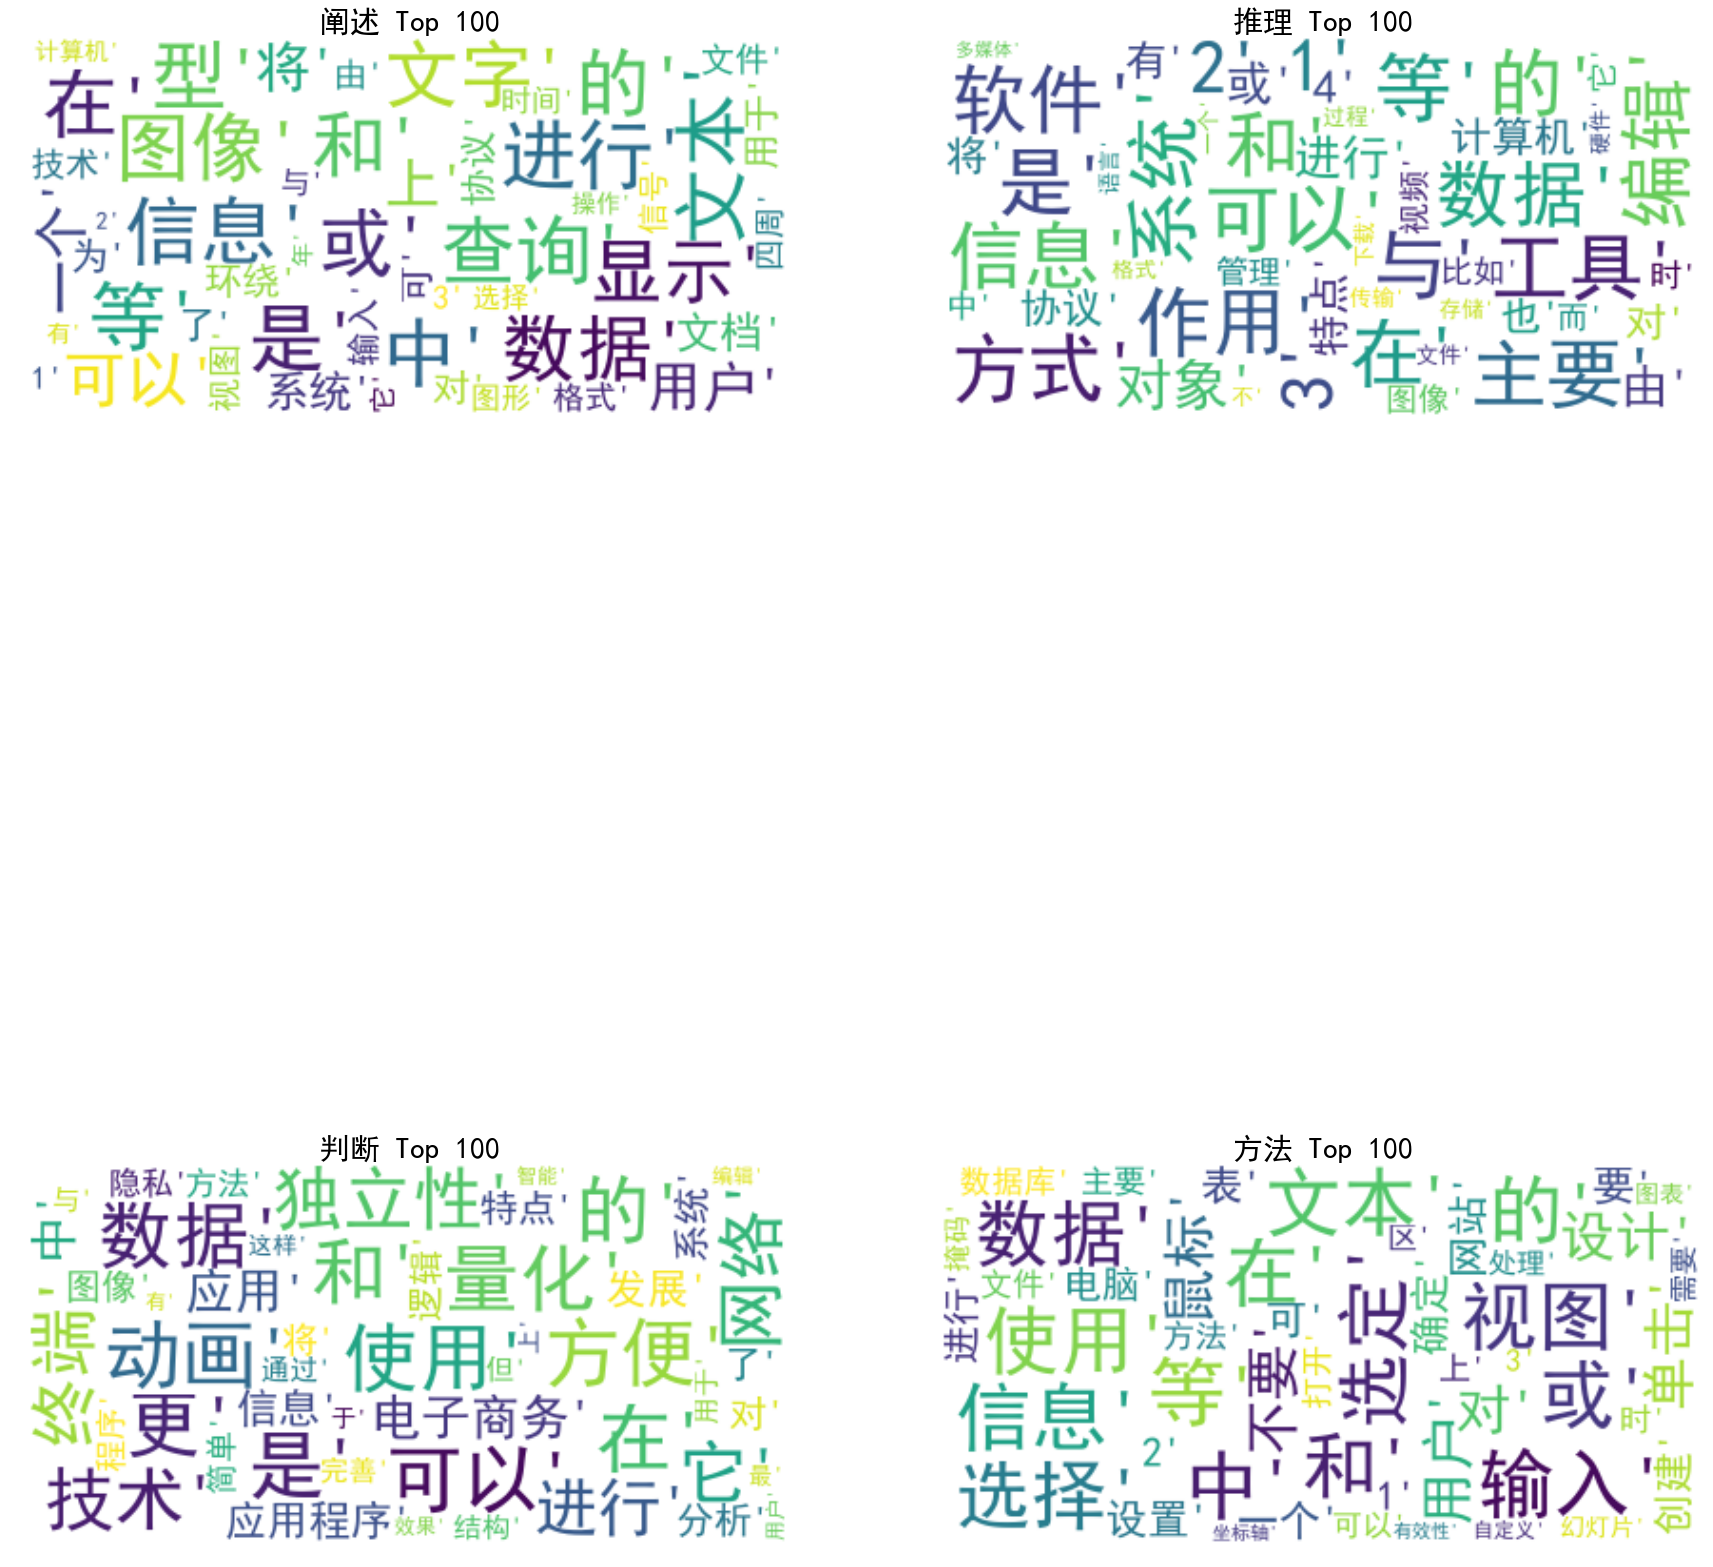

In [22]:
from collections import Counter
from wordcloud import WordCloud
 
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          font_path='simhei.ttf',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud
 
cat_desc = dict()
for cat in cat_label_df.cat.values:    
    text = df.loc[df['cat']==cat, 'content']
    text = (' '.join(map(str,text))).split(' ')
    cat_desc[cat]=text
    
fig,axes = plt.subplots(2, 2, figsize=(30, 38))
k=1
for i in range(2):
    for j in range(2):
        cat = label_to_cat[k]
        most100=Counter(cat_desc[cat]).most_common(100)
        ax = axes[i, j]
        ax.imshow(generate_wordcloud(most100), interpolation="bilinear")
        ax.axis('off')
        ax.set_title("{} Top 100".format(cat), fontsize=30)
        k+=1

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.content)
labels = df.label
# print(features.shape)
# print('-----------------------------')
# print(features)
# print(tfidf.vocabulary_)

{'数据压缩': 7622, '目的': 10055, '就是': 5741, '消除': 9299, '信息': 2562, '冗余': 3051, '数据压缩 目的': 7625, '目的 就是': 10060, '就是 消除': 5761, '消除 信息': 9300, '信息 冗余': 2578, '下载': 1336, '技术': 6817, '演变': 9401, '主从': 1678, '架构': 8646, '方式': 8039, '断点续传': 8001, '多线程': 5055, '并行': 6070, '网络蚂蚁': 11375, '镜像': 13703, '服务器': 8501, '主要': 1691, '下载工具': 1347, 'winrarwinzip7zip': 869, '下载 技术': 1339, '技术 演变': 6833, '演变 主从': 9402, '主从 架构': 1679, '架构 方式': 8648, '方式 断点续传': 8052, '断点续传 方式': 8002, '方式 多线程': 8048, '多线程 并行': 5056, '并行 方式': 6072, '方式 网络蚂蚁': 8061, '网络蚂蚁 镜像': 11376, '镜像 服务器': 13704, '服务器 方式': 8507, '方式 主要': 8041, '主要 下载工具': 1695, '下载工具 winrarwinzip7zip': 1348, '智能': 8310, '终端': 10930, '娱乐性': 5207, '实用性': 5542, '一身': 1213, '智能 终端': 8312, '终端 娱乐性': 10935, '娱乐性 实用性': 5208, '实用性 一身': 5543, '定制': 5478, '化发展': 3636, '着重于': 10184, '语音': 12448, '识别系统': 12335, '开发': 6226, '紧密': 10838, '服务': 8494, '业务': 1516, '大势所趋': 5073, '未来': 8521, '竞争': 10491, '平台': 6034, '终端 定制': 10936, '定制 化发展': 5479, '化发展 着重于': 3637, '着重于 语音': 10

In [16]:
from sklearn.feature_selection import chi2

N = 5
for cat, label in sorted(cat_to_label.items()):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(cat))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# '判断':
  . Most correlated unigrams:
       . 智能
       . 准确
       . 分析
       . 独立性
       . 方便
  . Most correlated bigrams:
       . 数据共享 数据
       . 数据 程序
       . 更加 准确
       . 分析 使用
       . 方便 分析
# '推理':
  . Most correlated unigrams:
       . 清楚
       . 数学方法
       . 标识
       . 比如
       . 作用
  . Most correlated bigrams:
       . 数学方法 组成
       . 一幅 图形
       . 图形 数学方法
       . 生成 一幅
       . 标识 对象
# '方法':
  . Most correlated unigrams:
       . 向导
       . 幻灯片
       . 不要
       . 掩码
       . 自定义
  . Most correlated bigrams:
       . 查询 向导
       . 采取 交叉
       . 视图 完成
       . 向导 设计
       . 输入 掩码
# '阐述':
  . Most correlated unigrams:
       . 幻灯片
       . 方便
       . 使用
       . 查询
       . 作用
  . Most correlated bigrams:
       . 位图 图像
       . 标识 对象
       . 日期 时间
       . 分析 使用
       . 方便 分析


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
 
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
 
# print(X_train_tfidf.shape)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

(2208, 3164)


In [34]:
def myPredict(sec):
    format_sec=" ".join([w for w in list(jieba.cut(remove_punctuation(sec))) if w not in stopwords])
    pred_cat_id=clf.predict(count_vect.transform([format_sec]))
    print(pred_cat_id[0])
    print(label_to_cat[pred_cat_id[0]])

In [35]:
myPredict('试分析讨论Windows的主要附件工具及其功能')

2
推理


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
 
from sklearn.model_selection import cross_val_score
 
 
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

F:\Python\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


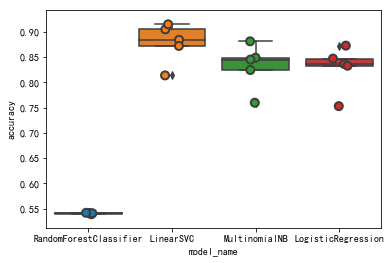

In [21]:
import seaborn as sns
 
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [22]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.878131
LogisticRegression        0.828565
MultinomialNB             0.831950
RandomForestClassifier    0.540578
Name: accuracy, dtype: float64

In [23]:
# print(type(df.label))

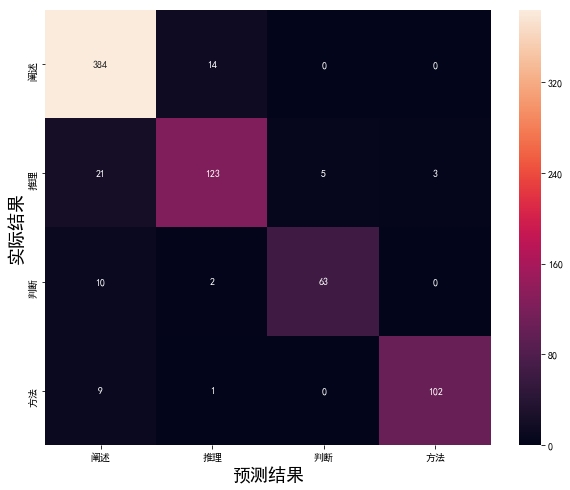

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
 
#训练模型
model = LinearSVC()
X_train, X_test, y_train, y_test= train_test_split(features, labels, test_size=0.25, stratify=labels)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(type(features))

#生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_label_df.cat.values, yticklabels=cat_label_df.cat.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)
plt.show()

In [77]:
from sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=cat_label_df['cat'].values))

accuracy 0.8941655359565808
             precision    recall  f1-score   support

         阐述       0.89      0.95      0.92       398
         推理       0.85      0.78      0.81       152
         判断       0.94      0.79      0.86        75
         方法       0.94      0.92      0.93       112

avg / total       0.89      0.89      0.89       737



In [26]:
rs=[]
test_df = pd.read_csv('other20200104u.csv')
# texts=test_df['content'].values.tolist()
test_df['content']=test_df['content'].apply(remove_punctuation)
test_df['content']=test_df['content'].map(lambda x: ' '.join(jieba.cut(x))) #以空格分隔jieba分词结果

print(features.shape)
# predictions = model.predict(test_df['content'])
print(0)

# for predicted in predictions:
#   rs.append(predicted)
# test_df['predict']=rs
# test_df.to_csv('F:\my_csv5.csv', mode='a', header=True)
# print(0)

(2945, 14254)
0


In [27]:
from IPython.display import display
 
for predicted in cat_label_df.label:
    for actual in cat_label_df.label:
        predicted_index=predicted-1
        actual_index=actual-1
        if predicted != actual and conf_mat[actual_index, predicted_index] >= 6:
            print("{} 预测为 {} : {} 例.".format(label_to_cat[actual], label_to_cat[predicted], conf_mat[actual_index, predicted_index]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['cat', 'content']])
            print('')

推理 预测为 阐述 : 22 例.


NameError: name 'indices_test' is not defined